In [ ]:
# %%
import pandas as pd
import os

# Find all portfolio files with prefix '25'
quant_dir = '/Users/amen/Documents/Quant/'
portfolio_files = [os.path.join(quant_dir, f) for f in os.listdir(quant_dir) if f.startswith('25') and f.endswith('_portfolio.pkl')]

print("Found portfolio files with prefix '25':")
print(f"data: {portfolio_files}")
print(f"length: {len(portfolio_files)}")

# Load the pickled data from the first file found (as an example)
if portfolio_files:
    file_path = portfolio_files[0]
    data = pd.read_pickle(file_path)

    # Extract the 'Current_Price' data
    current_price_df = data['Current_Price']

    print(f"\n--- Example: Loading data from {file_path} ---")
    print(f"Shape of saved data: {current_price_df.shape}")
    print("First 5 rows of saved data:")
    print(current_price_df.head())
else:
    print("No portfolio files found with prefix '25'.")

# %%
#length: 215
# after new additions: 
# length: 233





# AlphaVantage 

In [13]:
import requests
import config
import pandas as pd
import time

# Define multiple symbols to fetch
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
month = '2025-01'

# Dictionary to store individual DataFrames
dataframes = {}

print("Fetching data for symbols:", symbols)

for symbol in symbols:
    print(f"Fetching data for {symbol}...")
    
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&month={month}&outputsize=full&apikey={config.Alpha_Vantage}'
    r = requests.get(url)
    data = r.json()
    
    # Check if API returned valid data
    if 'Time Series (1min)' in data:
        # Create DataFrame for this symbol
        df_symbol = pd.DataFrame(data['Time Series (1min)']).T
        df_symbol.columns = ['open', 'high', 'low', 'close', 'volume']
        
        # Convert to datetime index
        df_symbol.index = pd.to_datetime(df_symbol.index)
        df_symbol.sort_index(inplace=True)
        
        # Convert to numeric types
        df_symbol = df_symbol.astype(float)
        
        # Store in dictionary
        dataframes[symbol] = df_symbol
        print(f"Successfully fetched {len(df_symbol)} records for {symbol}")
        
    else:
        print(f"Error fetching data for {symbol}: {data}")
    
    # Add delay to respect API rate limits (Alpha Vantage free tier: 25 calls per day, 5 calls per minute)
    # time.sleep(12)  # Wait 12 seconds between calls

# Combine all DataFrames into a single MultiIndex DataFrame
if dataframes:
    # Create MultiIndex columns: (symbol, metric)
    combined_dfs = []
    
    for symbol, df_symbol in dataframes.items():
        # Create MultiIndex for this symbol
        multi_columns = pd.MultiIndex.from_product([[symbol], df_symbol.columns], 
                                                  names=['symbol', 'metric'])
        df_symbol.columns = multi_columns
        combined_dfs.append(df_symbol)
    
    # Concatenate all DataFrames along columns (axis=1)
    final_df = pd.concat(combined_dfs, axis=1, sort=True)
    
    print(f"\nFinal DataFrame shape: {final_df.shape}")
    print(f"Symbols included: {list(dataframes.keys())}")
    print(f"Date range: {final_df.index.min()} to {final_df.index.max()}")
    print(f"MultiIndex structure: {final_df.columns}")
    
    # Display first few rows
    display(final_df.head())
else:
    print("No data was successfully fetched for any symbol")


Fetching data for symbols: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
Fetching data for AAPL...
Error fetching data for AAPL: {'Information': 'We have detected your API key as H05FI4R5M4YAOJU4 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fetching data for MSFT...
Error fetching data for MSFT: {'Information': 'We have detected your API key as H05FI4R5M4YAOJU4 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fetching data for GOOGL...
Error fetching data for GOOGL: {'Information': 'We have detected your API key as H05FI4R5M4YAOJU4 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.'}
Fe

AAPL


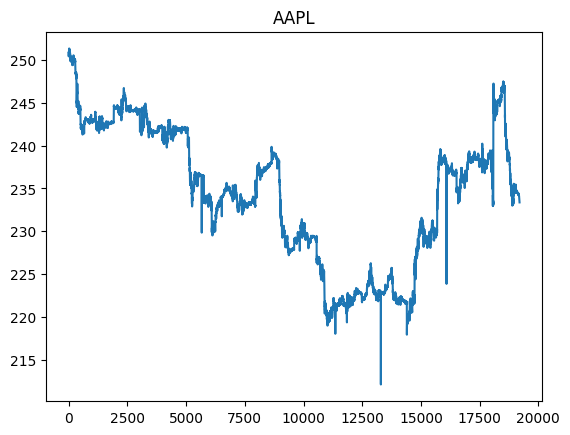

MSFT


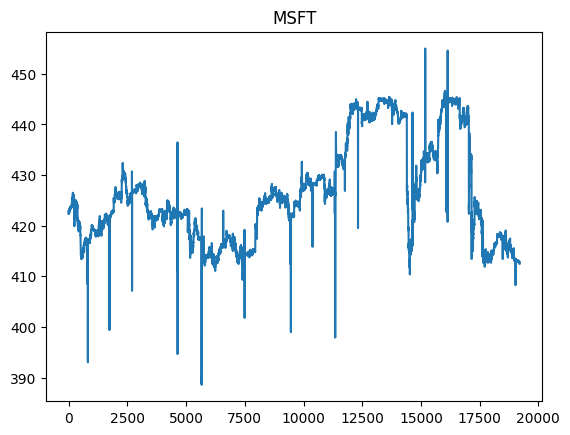

In [12]:
import matplotlib.pyplot as plt

for symbol in final_df.columns.get_level_values(0).unique():
    print(symbol)
    plt.plot(range(len(final_df)),final_df[symbol]['close'])
    plt.title(symbol)
    plt.show()

In [ ]:
# # Save the MultiIndex DataFrame to CSV
# if 'final_df' in locals():
#     filename = f'multi_symbol_data_{month.replace("-", "_")}.csv'
#     final_df.to_csv(filename)
#     print(f"Data saved to {filename}")
#     print(f"You can now load this data later with:")
#     print(f"df = pd.read_csv('{filename}', index_col=0, header=[0,1])")
# else:
#     print("No final_df available to save")


In [ ]:
# Function to add new symbols to existing MultiIndex DataFrame
def add_symbol_to_dataframe(existing_df, new_symbol, month='2025-01'):
    """
    Add a new symbol to an existing MultiIndex DataFrame
    """
    print(f"Adding {new_symbol} to existing DataFrame...")
    
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={new_symbol}&interval=1min&month={month}&outputsize=full&apikey={config.Alpha_Vantage}'
    r = requests.get(url)
    data = r.json()
    
    if 'Time Series (1min)' in data:
        # Create DataFrame for new symbol
        df_new = pd.DataFrame(data['Time Series (1min)']).T
        df_new.columns = ['open', 'high', 'low', 'close', 'volume']
        
        # Convert to datetime index
        df_new.index = pd.to_datetime(df_new.index)
        df_new.sort_index(inplace=True)
        df_new = df_new.astype(float)
        
        # Create MultiIndex for new symbol
        multi_columns = pd.MultiIndex.from_product([[new_symbol], df_new.columns], 
                                                  names=['symbol', 'metric'])
        df_new.columns = multi_columns
        
        # Concatenate with existing DataFrame
        combined_df = pd.concat([existing_df, df_new], axis=1, sort=True)
        
        print(f"Successfully added {new_symbol}. New shape: {combined_df.shape}")
        return combined_df
    else:
        print(f"Error fetching data for {new_symbol}: {data}")
        return existing_df

# Example usage (uncomment to add more symbols):
# final_df = add_symbol_to_dataframe(final_df, 'AMD')
# final_df = add_symbol_to_dataframe(final_df, 'META')


In [ ]:
# import requests
# import config
# import pandas as pd
# import time

# # Define multiple symbols to fetch
# symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META', 'AMZN']
# print(f"Fetching data for symbols: {symbols}")

# # Dictionary to store DataFrames for each symbol
# symbol_dataframes = {}

# # Fetch data for each symbol
# for i, symbol in enumerate(symbols):
#     print(f"Fetching data for {symbol} ({i+1}/{len(symbols)})...")
    
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&month=2025-01&outputsize=full&apikey={config.Alpha_Vantage}'
#     r = requests.get(url)
#     data = r.json()
    
#     # Check if we have valid data
#     if 'Time Series (1min)' in data:
#         # Create DataFrame for this symbol
#         df_symbol = pd.DataFrame(data['Time Series (1min)']).T
#         df_symbol.columns = ['open', 'high', 'low', 'close', 'volume']
        
#         # Convert to datetime index
#         df_symbol.index = pd.to_datetime(df_symbol.index)
#         df_symbol.sort_index(inplace=True)
        
#         # Convert to numeric types
#         df_symbol = df_symbol.astype(float)
        
#         # Store in dictionary
#         symbol_dataframes[symbol] = df_symbol
#         print(f"  {symbol}: {len(df_symbol)} rows fetched")
#     else:
#         print(f"  Error fetching {symbol}: {data}")
    
#     # Add delay to respect API rate limits (Alpha Vantage free tier: 25 requests per day, 5 per minute)
#     if i < len(symbols) - 1:  # Don't sleep after the last symbol
#         print("  Waiting 15 seconds for API rate limit...")
#         time.sleep(15)

# print(f"\nSuccessfully fetched data for {len(symbol_dataframes)} symbols")


In [ ]:
import requests
import config
import pandas as pd
import time

# Define multiple symbols to fetch
symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA']
month = '2025-01'

# Dictionary to store individual DataFrames
dataframes = {}

print("Fetching data for symbols:", symbols)

for symbol in symbols:
    print(f"Fetching data for {symbol}...")
    
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&month={month}&outputsize=full&apikey={config.Alpha_Vantage}'
    r = requests.get(url)
    data = r.json()
    
    # Check if API returned valid data
    if 'Time Series (1min)' in data:
        # Create DataFrame for this symbol
        df_symbol = pd.DataFrame(data['Time Series (1min)']).T
        df_symbol.columns = ['open', 'high', 'low', 'close', 'volume']
        
        # Convert to datetime index
        df_symbol.index = pd.to_datetime(df_symbol.index)
        df_symbol.sort_index(inplace=True)
        
        # Convert to numeric types
        df_symbol = df_symbol.astype(float)
        
        # Store in dictionary
        dataframes[symbol] = df_symbol
        print(f"Successfully fetched {len(df_symbol)} records for {symbol}")
        
    else:
        print(f"Error fetching data for {symbol}: {data}")
    
    # Add delay to respect API rate limits (Alpha Vantage free tier: 25 calls per day, 5 calls per minute)
    time.sleep(12)  # Wait 12 seconds between calls

# Combine all DataFrames into a single MultiIndex DataFrame
if dataframes:
    # Create MultiIndex columns: (symbol, metric)
    combined_dfs = []
    
    for symbol, df_symbol in dataframes.items():
        # Create MultiIndex for this symbol
        multi_columns = pd.MultiIndex.from_product([[symbol], df_symbol.columns], 
                                                  names=['symbol', 'metric'])
        df_symbol.columns = multi_columns
        combined_dfs.append(df_symbol)
    
    # Concatenate all DataFrames along columns (axis=1)
    final_df = pd.concat(combined_dfs, axis=1, sort=True)
    
    print(f"\nFinal DataFrame shape: {final_df.shape}")
    print(f"Symbols included: {list(dataframes.keys())}")
    print(f"Date range: {final_df.index.min()} to {final_df.index.max()}")
    print(f"MultiIndex structure: {final_df.columns}")
    
    # Display first few rows
    final_df.head()
else:
    print("No data was successfully fetched for any symbol")

Fetching data for symbols: ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META', 'AMZN']
Fetching data for AAPL (1/7)...
  AAPL: 19186 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for MSFT (2/7)...
  MSFT: 19099 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for GOOGL (3/7)...
  GOOGL: 18995 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for TSLA (4/7)...
  TSLA: 19200 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for NVDA (5/7)...
  NVDA: 19200 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for META (6/7)...
  META: 18984 rows fetched
  Waiting 15 seconds for API rate limit...
Fetching data for AMZN (7/7)...
  AMZN: 19059 rows fetched

Successfully fetched data for 7 symbols


In [43]:
df_symbol

,open,high,low,close,volume
2025-01-02 04:00:00,220.440,221.41,219.99,221.030,2974.0
2025-01-02 04:01:00,221.130,221.19,220.75,221.010,116.0
2025-01-02 04:02:00,221.040,221.08,220.75,220.810,307.0
2025-01-02 04:03:00,220.960,220.97,220.69,220.690,1897.0
2025-01-02 04:04:00,220.670,220.80,220.61,220.620,1458.0
...,...,...,...,...,...
2025-01-31 19:55:00,236.301,236.43,236.30,236.430,1079.0
2025-01-31 19:56:00,236.325,236.50,236.00,236.150,2625.0
2025-01-31 19:57:00,236.400,236.40,236.10,236.100,347.0
2025-01-31 19:58:00,236.200,236.25,236.00,236.250,2349.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import alphavantage as av


av.

SyntaxError: invalid syntax (2082885497.py, line 7)

In [ ]:
import requests
import config
# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey=demo'

symbol = 'AAPL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&month=2025-01&outputsize=full&apikey={config.Alpha_Vantage}'
r = requests.get(url)
data = r.json()
import pandas as pd
print(data)
df = pd.DataFrame(data['Time Series (1min)'],).T
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['date'] = df.index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
# df.head(50)

print(len(df))
df #.tail(200)


{'Meta Data': {'1. Information': 'Intraday (1min) open, high, low, close prices and volume', '2. Symbol': 'AAPL', '3. Last Refreshed': '2025-01-31 19:59:00', '4. Interval': '1min', '5. Output Size': 'Full size', '6. Time Zone': 'US/Eastern'}, 'Time Series (1min)': {'2025-01-31 19:59:00': {'1. open': '233.5252', '2. high': '233.5451', '3. low': '233.3656', '4. close': '233.3696', '5. volume': '2712'}, '2025-01-31 19:58:00': {'1. open': '233.4154', '2. high': '233.5751', '3. low': '233.3855', '4. close': '233.5052', '5. volume': '5654'}, '2025-01-31 19:57:00': {'1. open': '233.5352', '2. high': '233.5352', '3. low': '233.4105', '4. close': '233.4454', '5. volume': '6581'}, '2025-01-31 19:56:00': {'1. open': '233.6050', '2. high': '233.6549', '3. low': '233.5052', '4. close': '233.5052', '5. volume': '2892'}, '2025-01-31 19:55:00': {'1. open': '233.7048', '2. high': '233.7048', '3. low': '233.6050', '4. close': '233.6050', '5. volume': '963'}, '2025-01-31 19:54:00': {'1. open': '233.6948'

,open,high,low,close,volume
date,,,,,
2025-01-02 04:00:00,251.3137,251.3137,250.0167,250.7749,834
2025-01-02 04:01:00,250.7849,250.9545,250.6752,250.7350,1175
2025-01-02 04:02:00,250.7849,250.8448,250.6253,250.6253,847
2025-01-02 04:03:00,250.7151,250.7151,250.3958,250.3958,1692
2025-01-02 04:04:00,250.3759,250.5654,250.3559,250.4457,633
...,...,...,...,...,...
2025-01-31 19:55:00,233.7048,233.7048,233.6050,233.6050,963
2025-01-31 19:56:00,233.6050,233.6549,233.5052,233.5052,2892
2025-01-31 19:57:00,233.5352,233.5352,233.4105,233.4454,6581


# Polygon

In [ ]:
import requests
import config
import pandas as pd

# url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey=demo'

symbol = 'AAPL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&month=2025-01&outputsize=full&apikey={config.Alpha_Vantage}'
r = requests.get(url)
data = r.json()
print(data)

# Create the basic DataFrame first
df = pd.DataFrame(data['Time Series (1min)']).T
df.columns = ['open', 'high', 'low', 'close', 'volume']

# Convert to datetime index
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Convert to numeric types
df = df.astype(float)

# Create MultiIndex columns with symbol as level 1 and OHLCV as level 0
multi_columns = pd.MultiIndex.from_product([[symbol], df.columns,], 
                                          names=['symbol','metric'])
df.columns = multi_columns

print(f"Length: {len(df)}")
print(f"MultiIndex structure: {df.columns}")
df.head()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import requests
import json
import time
import random
import re
import datetime
import pytz
import pickle


preprocessed_data = pd.read_csv('cleaned_preprocessed.csv')

# print(preprocessed_data.head())
# print(preprocessed_data.info())
# print(preprocessed_data.describe())
# print(preprocessed_data.columns)
# print(preprocessed_data.shape)
# print(preprocessed_data.dtypes)
# print(preprocessed_data.isnull().sum())
print(preprocessed_data)

print(f"-----------------")
# print(preprocessed_data.date.tail(50))


        Unnamed: 0                       date  coin      high       low  \
0                0  2015-06-30 13:00:00-07:00  DASH  0.011165  0.011165   
1                1  2015-06-30 13:00:00-07:00   LTC  0.015170  0.015170   
2                2  2015-06-30 13:00:00-07:00   STR  0.000013  0.000013   
3                3  2015-06-30 13:05:00-07:00  DASH  0.011115  0.011104   
4                4  2015-06-30 13:05:00-07:00   LTC  0.015170  0.015170   
...            ...                        ...   ...       ...       ...   
631582      631581  2017-06-30 12:55:00-07:00  DASH  0.072233  0.072150   
631583      631583  2017-06-30 12:55:00-07:00   STR  0.000011  0.000011   
631584      631585  2017-06-30 13:00:00-07:00   LTC  0.016154  0.016071   
631585      631584  2017-06-30 13:00:00-07:00  DASH  0.072150  0.072074   
631586      631586  2017-06-30 13:00:00-07:00   STR  0.000011  0.000011   

            open     close    volume   quoteVolume  weightedAverage  ...  \
0       0.011165  0.011

In [2]:
preprocessed_data

,Unnamed: 0,date,coin,high,low,open,close,volume,quoteVolume,weightedAverage,...,open_s_roll_30,volume_s_roll_7,volume_s_roll_14,volume_s_roll_30,quoteVolume_s_roll_7,quoteVolume_s_roll_14,quoteVolume_s_roll_30,weightedAverage_s_roll_7,weightedAverage_s_roll_14,weightedAverage_s_roll_30
0,0,2015-06-30 13:00:00-07:00,DASH,0.011165,0.011165,0.011165,0.011165,0.000000,0.000000,0.011165,...,-9.999000e-06,0.000000,-7.837233e-18,-3.932040e-18,0.000000,7.315577e-16,2.220446e-16,-2.431286e-05,-2.142071e-05,-9.999000e-06
1,1,2015-06-30 13:00:00-07:00,LTC,0.015170,0.015170,0.015170,0.015170,0.128168,8.448907,0.015170,...,1.133300e-05,0.005044,-6.844384e-03,-4.272281e-03,0.319482,-4.519920e-01,-2.816302e-01,1.850857e-05,5.777857e-06,1.133600e-05
2,2,2015-06-30 13:00:00-07:00,STR,0.000013,0.000013,0.000013,0.000013,0.063516,4882.109915,0.000013,...,4.000000e-09,-0.007207,-4.536875e-03,-2.117208e-03,-555.301416,-3.487221e+02,-1.627370e+02,1.714286e-08,1.428571e-08,4.000000e-09
3,3,2015-06-30 13:05:00-07:00,DASH,0.011115,0.011104,0.011115,0.011104,0.134905,12.139066,0.011113,...,-9.999000e-06,0.000000,-7.837233e-18,-3.932040e-18,0.000000,7.315577e-16,2.220446e-16,-2.431286e-05,-2.142071e-05,-9.999000e-06
4,4,2015-06-30 13:05:00-07:00,LTC,0.015170,0.015170,0.015170,0.015170,0.004257,0.280592,0.015170,...,1.133300e-05,0.005044,-6.844384e-03,-4.272281e-03,0.319482,-4.519920e-01,-2.816302e-01,1.850857e-05,5.777857e-06,1.133600e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631582,631581,2017-06-30 12:55:00-07:00,DASH,0.072233,0.072150,0.072230,0.072150,2.229033,30.884880,0.072172,...,3.001200e-05,-0.089960,-9.199033e-02,2.043148e-02,-1.280617,-1.295348e+00,2.762159e-01,6.185571e-05,3.055857e-05,2.196333e-05
631583,631583,2017-06-30 12:55:00-07:00,STR,0.000011,0.000011,0.000011,0.000011,0.826358,74083.850819,0.000011,...,3.333333e-10,-0.321995,-1.454299e-01,-9.973190e-02,-28849.014202,-1.297331e+04,-9.012649e+03,-1.694066e-20,-2.857143e-09,2.333333e-09
631584,631585,2017-06-30 13:00:00-07:00,LTC,0.016154,0.016071,0.016079,0.016154,9.174810,569.048247,0.016123,...,-5.345667e-06,0.544805,2.336024e-01,9.406621e-02,34.008075,1.444492e+01,5.936097e+00,-1.060571e-05,1.924286e-06,-4.200000e-06
631585,631584,2017-06-30 13:00:00-07:00,DASH,0.072150,0.072074,0.072146,0.072138,3.418187,47.384701,0.072137,...,2.001233e-05,0.267361,2.297594e-01,1.245176e-02,3.696456,3.183608e+00,1.633995e-01,3.299714e-05,3.683000e-05,1.564433e-05


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import requests
import json
import time
import random
import re
import datetime
import pytz
import pickle


preprocessed_data = pd.read_csv('cleaned.csv')

# print(preprocessed_data.head())
# print(preprocessed_data.info())
# print(preprocessed_data.describe())
# print(preprocessed_data.columns)
# print(preprocessed_data.shape)
# print(preprocessed_data.dtypes)
# print(preprocessed_data.isnull().sum())
print(preprocessed_data)

print(f"-----------------")
# print(preprocessed_data.date.tail(50))


                             date  coin      high       low      open  \
0       2015-06-30 13:00:00-07:00  DASH  0.011165  0.011165  0.011165   
1       2015-06-30 13:00:00-07:00   LTC  0.015170  0.015170  0.015170   
2       2015-06-30 13:00:00-07:00   STR  0.000013  0.000013  0.000013   
3       2015-06-30 13:05:00-07:00  DASH  0.011115  0.011104  0.011115   
4       2015-06-30 13:05:00-07:00   LTC  0.015170  0.015170  0.015170   
...                           ...   ...       ...       ...       ...   
631582  2017-06-30 12:55:00-07:00   LTC  0.016108  0.016069  0.016099   
631583  2017-06-30 12:55:00-07:00   STR  0.000011  0.000011  0.000011   
631584  2017-06-30 13:00:00-07:00  DASH  0.072150  0.072074  0.072146   
631585  2017-06-30 13:00:00-07:00   LTC  0.016154  0.016071  0.016079   
631586  2017-06-30 13:00:00-07:00   STR  0.000011  0.000011  0.000011   

           close     volume   quoteVolume  weightedAverage  
0       0.011165   0.000000      0.000000         0.011165  
1

In [5]:
preprocessed_data

,date,coin,high,low,open,close,volume,quoteVolume,weightedAverage
0,2015-06-30 13:00:00-07:00,DASH,0.011165,0.011165,0.011165,0.011165,0.000000,0.000000,0.011165
1,2015-06-30 13:00:00-07:00,LTC,0.015170,0.015170,0.015170,0.015170,0.128168,8.448907,0.015170
2,2015-06-30 13:00:00-07:00,STR,0.000013,0.000013,0.000013,0.000013,0.063516,4882.109915,0.000013
3,2015-06-30 13:05:00-07:00,DASH,0.011115,0.011104,0.011115,0.011104,0.134905,12.139066,0.011113
4,2015-06-30 13:05:00-07:00,LTC,0.015170,0.015170,0.015170,0.015170,0.004257,0.280592,0.015170
...,...,...,...,...,...,...,...,...,...
631582,2017-06-30 12:55:00-07:00,LTC,0.016108,0.016069,0.016099,0.016108,12.627617,785.437513,0.016077
631583,2017-06-30 12:55:00-07:00,STR,0.000011,0.000011,0.000011,0.000011,0.826358,74083.850819,0.000011
631584,2017-06-30 13:00:00-07:00,DASH,0.072150,0.072074,0.072146,0.072138,3.418187,47.384701,0.072137
631585,2017-06-30 13:00:00-07:00,LTC,0.016154,0.016071,0.016079,0.016154,9.174810,569.048247,0.016123
